# Libraries

In [51]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from transformers import TFAutoModelForSequenceClassification, AutoTokenizer
import tensorflow as tf
from sklearn.model_selection import train_test_split

In [19]:
import tensorflow as tf
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


# Load data

In [20]:
# Load data from hugging face
df = pd.read_parquet("hf://datasets/TimKoornstra/synthetic-financial-tweets-sentiment/data/train-00000-of-00001.parquet")

# Descriptive Analysis

In [4]:
print(f"Shape of the data set: {df.shape}")
print(df.head())

Shape of the data set: (1428771, 2)
                                               tweet  sentiment
0  💰 Cashing out stocks today has left me with a ...          2
1  💸 Losing half my investments in the last month...          2
2  📉 Crypto bubble finally bursts! The crypto tra...          2
3  🔥 The blazing inferno engulfs the stock market...          2
4  🥶 My stocks are stuck in an icy grip today. Fi...          2


In [5]:
df.isnull().sum()

tweet        0
sentiment    0
dtype: int64

There are no any  missing values

In [6]:
df['sentiment'].value_counts()

sentiment
1    486366
2    486133
0    456272
Name: count, dtype: int64

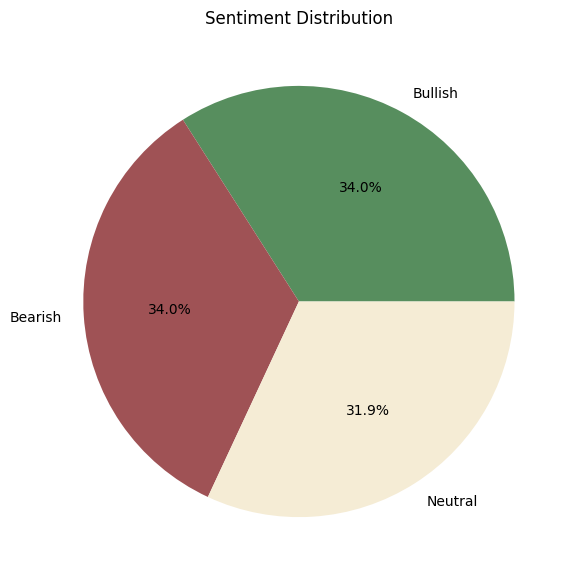

In [21]:
# Hex color codes for pastel-like colors
colors = ['#578E5E', '#9F5255', '#F5ECD5']  # green, red, pastel cream
labels = {0: 'Neutral', 1: 'Bullish', 2: 'Bearish'}

# Get sentiment counts and remap the labels
sentiment_counts = df['sentiment'].value_counts()
sentiment_labels = [labels[sent] for sent in sentiment_counts.index]

# Plot the pie chart
plt.figure(figsize=(7,7))
plt.pie(sentiment_counts, labels=sentiment_labels, colors=colors, autopct='%1.1f%%')
plt.title('Sentiment Distribution')
plt.show()

Data set is a well balance data set

In [38]:
# Check for duplicate values in the 'tweet' column
duplicates = df[df['tweet'].duplicated()]

# Display the count of duplicate rows
print(f"Number of duplicate tweets: {len(duplicates)}")

# Display the duplicated rows (if any)
if not duplicates.empty:
    print(duplicates.head())
else:
    print("No duplicate tweets found.")

Number of duplicate tweets: 0
No duplicate tweets found.


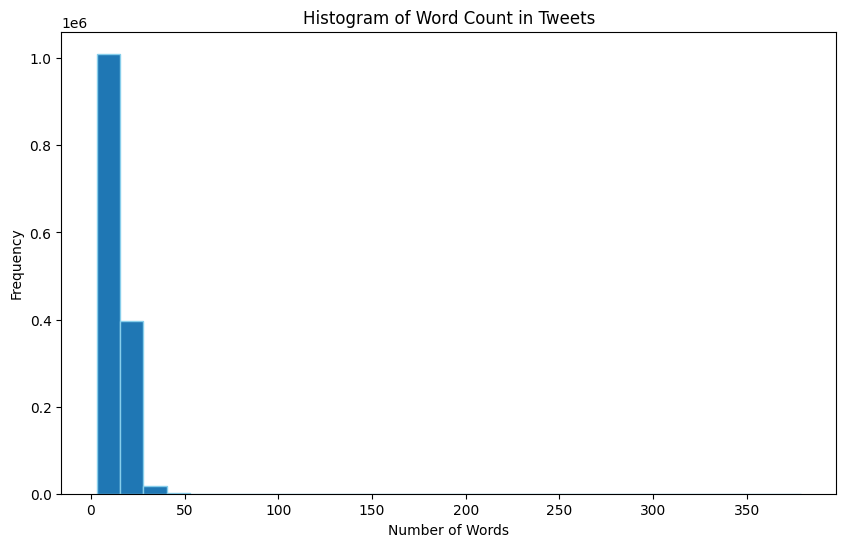

In [36]:
# Add a new column 'word_count' to count the number of words in each tweet
df['word_count'] = df['tweet'].apply(lambda x: len(str(x).split()))

# Plot a histogram of the word count
plt.figure(figsize=(10, 6))
plt.hist(df['word_count'], bins=30, edgecolor='skyblue')
plt.title('Histogram of Word Count in Tweets')
plt.xlabel('Number of Words')
plt.ylabel('Frequency')
plt.show()

## Data Preprocessing

                                               tweet  sentiment  word_count
0  💰 Cashing out stocks today has left me with a ...          2          21
1  💸 Losing half my investments in the last month...          2          17
2  📉 Crypto bubble finally bursts! The crypto tra...          2          13
3  🔥 The blazing inferno engulfs the stock market...          2          13
4  🥶 My stocks are stuck in an icy grip today. Fi...          2          15


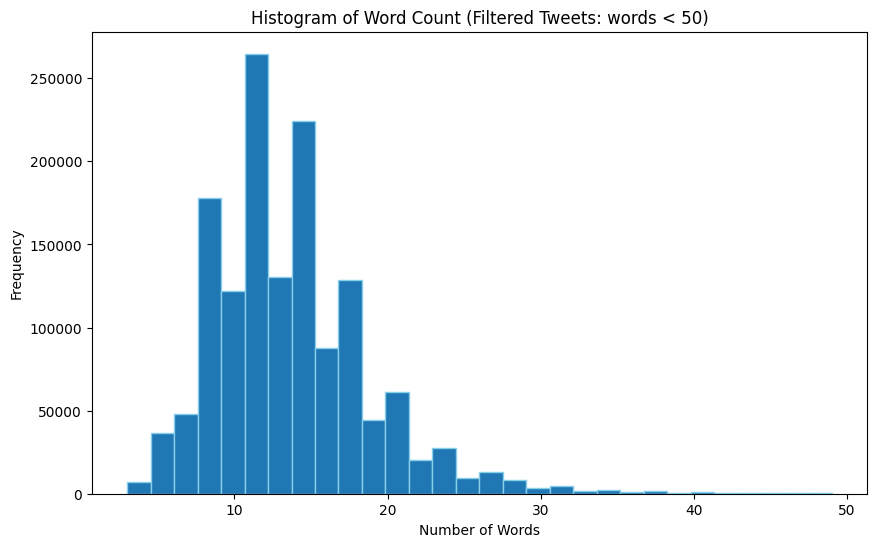

In [35]:
# Filter tweets with word count greater than 10 and less than 50
filtered_df = df[(df['word_count'] < 50)]

# Display the first few rows of the filtered DataFrame
print(filtered_df.head())

# Plot a histogram for filtered tweets
plt.figure(figsize=(10, 6))
plt.hist(filtered_df['word_count'], bins=30, edgecolor='skyblue')
plt.title('Histogram of Word Count (Filtered Tweets: words < 50)')
plt.xlabel('Number of Words')
plt.ylabel('Frequency')
plt.show()

In [71]:
# Reduce the dataset to 100,000 random samples
reduced_df = df.sample(n=5000, random_state=42)  # random_state ensures reproducibility

# Verify the new shape of the dataset
print(f"Shape of the reduced dataset: {reduced_df.shape}")

Shape of the reduced dataset: (5000, 3)


## Tokenize data

In [72]:
max_length = 128

# Load tokenizer and model
tokenizer = AutoTokenizer.from_pretrained('yiyanghkust/finbert-tone')
model = TFAutoModelForSequenceClassification.from_pretrained('yiyanghkust/finbert-tone', num_labels=3)

# Split dataset into training and validation
train_texts, val_texts, train_labels, val_labels = train_test_split(reduced_df['tweet'], reduced_df['sentiment'], test_size=0.3,
                                                                    random_state=42)

# Tokenize the data
train_encodings = tokenizer(list(train_texts), truncation=True, padding=True, max_length=max_length) # max length 256 to 128
val_encodings = tokenizer(list(val_texts), truncation=True, padding=True, max_length=max_length)

Some layers from the model checkpoint at yiyanghkust/finbert-tone were not used when initializing TFBertForSequenceClassification: ['dropout_37']
- This IS expected if you are initializing TFBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertForSequenceClassification were initialized from the model checkpoint at yiyanghkust/finbert-tone.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertForSequenceClassification for predictions without further training.


In [73]:
# Check size of encoded data sets (as there were some mismatch)
print(f"Train Encodings: {len(train_encodings['input_ids'])}, Validation Encodings: {len(val_encodings['input_ids'])}")

Train Encodings: 3500, Validation Encodings: 1500


In [74]:
# Convert to TensorFlow datasets
train_dataset = tf.data.Dataset.from_tensor_slices((dict(train_encodings), list(train_labels))).batch(32) # batch size 16 to 32
val_dataset = tf.data.Dataset.from_tensor_slices((dict(val_encodings), list(val_labels))).batch(32)

# Compile the model
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=5e-5), # learning rate 5e-5 to 1e-5
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy']
)

# Train the model
history = model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=3  # You can adjust the number of epochs
)

# Evaluate the model
loss, accuracy = model.evaluate(val_dataset)
print(f"Validation Loss: {loss}")
print(f"Validation Accuracy: {accuracy}")

Epoch 1/3


2025-01-05 13:04:30.521574: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


110/110 [==============================] - ETA: 0s - loss: 0.5526 - accuracy: 0.8251

2025-01-05 13:14:49.369447: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


110/110 [==============================] - 686s 6s/step - loss: 0.5526 - accuracy: 0.8251 - val_loss: 0.3816 - val_accuracy: 0.8640
Epoch 2/3
110/110 [==============================] - 578s 5s/step - loss: 0.0727 - accuracy: 0.9763 - val_loss: 0.4796 - val_accuracy: 0.8653
Epoch 3/3
47/47 [==============================] - 47s 1s/step - loss: 0.5954 - accuracy: 0.8733
Validation Loss: 0.5953708291053772
Validation Accuracy: 0.8733333349227905


2025-01-05 13:36:13.417070: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


47/47 [==============================] - 62s 1s/step


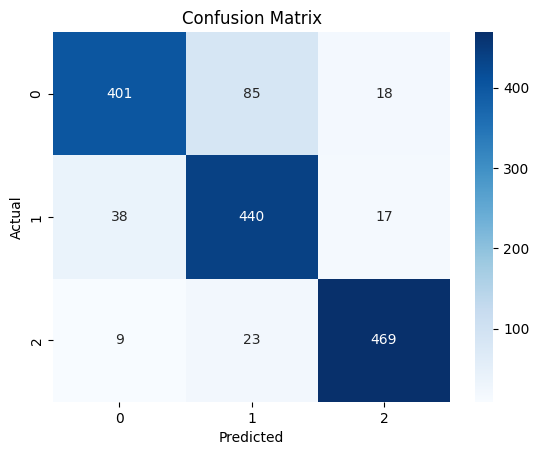

              precision    recall  f1-score   support

           0       0.90      0.80      0.84       504
           1       0.80      0.89      0.84       495
           2       0.93      0.94      0.93       501

    accuracy                           0.87      1500
   macro avg       0.88      0.87      0.87      1500
weighted avg       0.88      0.87      0.87      1500



In [75]:
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns

y_pred = model.predict(val_dataset)
y_pred_classes = np.argmax(y_pred.logits, axis=1)
y_true = np.array(val_labels)

# Confusion Matrix
cm = confusion_matrix(y_true, y_pred_classes)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

# Classification Report
print(classification_report(y_true, y_pred_classes))

## Save the model

In [76]:
# Save the model
model.save("saved_models/finbert_model_v3")

INFO:tensorflow:Assets written to: saved_models/finbert_model_v3/assets


INFO:tensorflow:Assets written to: saved_models/finbert_model_v3/assets


## Load the model

In [94]:
# Load the model
model = tf.keras.models.load_model("saved_models/finbert_model_v3")

## Use for predictions

In [95]:
# Tokenize the new input text
new_texts = ["Stock prices are going up!", 
             "I'm feeling bearish about the market.", 
             "it is not a bullish market", 
             "it is a bullish market", 
             "JKH is on fire",
             "We can't  rely on crypto anymore",
             "there is no right or wrong answer in cse"]
new_encodings = tokenizer(new_texts, truncation=True, padding=True, max_length=max_length, return_tensors="tf")

# Make predictions
predictions = model(new_encodings)["logits"]
predicted_class = tf.argmax(predictions, axis=1)
# Print(predicted_class.numpy())  # Prints 0 (neutral), 1 (bullish), or 2 (bearish)

# Map market sentiment to the predictions
market_sentiment = [labels[pred] for pred in predicted_class.numpy()]

# Print results
print("Classification results\n")
results_df = pd.DataFrame({"text": new_texts, "market sentiment": market_sentiment})
results_df

2025-01-12 15:52:23.827748: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


Classification results



,text,market sentiment
0,Stock prices are going up!,Bullish
1,I'm feeling bearish about the market.,Bearish
2,it is not a bullish market,Bearish
3,it is a bullish market,Bullish
4,JKH is on fire,Bearish
5,We can't rely on crypto anymore,Bearish
6,there is no right or wrong answer in cse,Bearish
